In [254]:
#import necessary libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [255]:
# Import the GRF data and store in a dataframe
df = pd.read_csv("tred02.csv")

# Drop unnamed and empty columns for acceleration
df = df.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'])

# Rename columns
df = df.rename(columns={'PRV142-L': 'Total', 'Unnamed: 0': 'Time'})

# Drop first rows (strings)
df = df.drop(index=0)

# Rearrange columns so every single dataset follows the same order: 'Time', 'Forefoot', 'Midfoot', 'Heel', 'Total'
def rearrange_columns(df):
    cols = ['Time', 'Forefoot', 'Midfoot', 'Heel', 'Total']
    cols_present = df.columns.tolist()
    cols_rearranged = [col for col in cols if col in cols_present] + [col for col in cols_present if col not in cols]
    return df[cols_rearranged]

df = rearrange_columns(df)

# Change datatype to float
df['Time'] = df['Time'].astype(float)
df['Forefoot'] = df['Forefoot'].astype(float)
df['Midfoot'] = df['Midfoot'].astype(float)
df['Heel'] = df['Heel'].astype(float)
df['Total'] = df['Total'].astype(float)

# Import  metadata and set 'Comment' as index
metadata = pd.read_excel('labels tredmill.xlsx', index_col='Comment')

# Extract body weight for each subject
subjectName = 'Tred002'
body_weight = metadata.loc[subjectName, 'Mass (kg)']

# Normalize GRF columns by body weight
df['NormForefoot'] = df['Forefoot'] / body_weight
df['NormMidfoot'] = df['Midfoot'] / body_weight
df['NormHeel'] = df['Heel'] / body_weight
df['NormTotal'] = df['Total'] / body_weight

# Define the distance from each sensor to the ankle joint center
#sensor_to_ankle = {"NormForefoot": 0.1, "NormMidfoot": 0.2, "NormHeel": 0.05}  

# Calculate the moment arm for each zone
#cop = df[["NormForefoot", "NormMidfoot", "NormHeel"]].to_numpy()
#moment_arm = cop - np.array([sensor_to_ankle["NormForefoot"], sensor_to_ankle["NormMidfoot"], sensor_to_ankle["NormHeel"]]).reshape(1, -1)

# Calculate the plantar flexion moment for each zone
#force = df[["NormForefoot", "NormMidfoot", "NormHeel"]].to_numpy()
#plantar_flexion_moment = force * moment_arm

# Calculate the total plantar flexion moment
#total_plantar_flexion_moment = np.sum(plantar_flexion_moment, axis=1)

# Add the total plantar flexion moment to the DataFrame
#df["Plantar Flexion Moment"] = total_plantar_flexion_moment

# Print the resulting DataFrame
df.head()

/var/folders/tx/zndgmlw50p13w72wm7zv8xnm0000gn/T/ipykernel_40344/497154349.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("tred02.csv")


,Time,Forefoot,Midfoot,Heel,Total,NormForefoot,NormMidfoot,NormHeel,NormTotal
1,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
2,0.01,139.38,22.08,172.50,333.96,2.212381,0.350476,2.738095,5.300952
3,0.02,134.55,29.67,169.74,333.96,2.135714,0.470952,2.694286,5.300952
4,0.03,137.31,24.84,169.74,331.89,2.179524,0.394286,2.694286,5.268095
5,0.04,129.72,26.91,166.98,323.61,2.059048,0.427143,2.650476,5.136667


In [256]:
# Define the function to calculate Achilles tendon loading
def moment_loadsol_calc_6_22_22(MA_num, force_vals, mass):
    geom_dict = np.array([[0.03875, 0.11415, 0.1908, 0.051, 1], #v tan
                          [0.0415, 0.12165, 0.2027, 0.054, 1], # W navy
                          [0.0425, 0.12665, 0.2137, 0.0575, 1], # X black 
                          [0.045, 0.1325, 0.223, 0.06, 1], # Y red
                          [0.0475, 0.1400, 0.233, 0.0625, 1]]) # baby blue
    
    vals = geom_dict[MA_num-1, :-1]
    COPs = vals - vals[-1]
    COP_real = [vals[0]/2 - vals[-1],
                vals[0] + vals[1]/2 - vals[-1],
                vals[0] + vals[1] + vals[2]/2 - vals[-1]]

    moment = force_vals[:,0] * COP_real[0] + force_vals[:,1] * COP_real[1] + force_vals[:,2] * COP_real[2]

    T_F = moment / geom_dict[MA_num-1, -1]
    T_F_norm = T_F / (9.8 * mass)
    
    return T_F_norm

# Define the input variables
MA_num = 4 # Choose the row in the geom_dict variable 
force_vals = df[['NormForefoot', 'NormMidfoot', 'NormHeel']].to_numpy()
mass = 75 # in kg

# Calculate the Achilles tendon loading
AT_loading = moment_loadsol_calc_6_22_22(MA_num, force_vals, mass)

# Add the AT loading column to the DataFrame
df['AT_loading'] = AT_loading

# Show the updated DataFrame
df.head()


,Time,Forefoot,Midfoot,Heel,Total,NormForefoot,NormMidfoot,NormHeel,NormTotal,AT_loading
1,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.01,139.38,22.08,172.50,333.96,2.212381,0.350476,2.738095,5.300952,0.000765
3,0.02,134.55,29.67,169.74,333.96,2.135714,0.470952,2.694286,5.300952,0.000763
4,0.03,137.31,24.84,169.74,331.89,2.179524,0.394286,2.694286,5.268095,0.000756
5,0.04,129.72,26.91,166.98,323.61,2.059048,0.427143,2.650476,5.136667,0.000751


In [257]:
time_ranges_labels = ['warm_up', 'Slow1', 'Medium1', 'Fast1', 'Slow2', 'Medium2', 'Fast2', 'Slow3', 'Medium3', 'Fast3', 'Slow4', 'Medium4', 'Fast4', 'Slow5', 'Medium5', 'Fast5', 'Slow6', 'Medium6', 'Fast6', 'cool_down']
time_ranges_values = [30, 175, 176, 215, 225, 250, 251, 277, 280, 340, 350, 375, 380, 392, 400, 457, 461, 494, 497, 523, 528, 582, 585, 620, 621, 654, 655, 722, 727, 754, 757, 777, 786, 842, 845, 883, 885, 910, 914, 1098]
incline_ranges_labels = ['0', '10', '10', '10', '0', '0', '0', '20', '20', '20', '5', '5', '5', '25', '25', '25', '15', '15', '15','0']

def map_time_to_speed(time):
    for i in range(0, len(time_ranges_values), 2):
        start = time_ranges_values[i]
        end = time_ranges_values[i+1] if i+1 < len(time_ranges_values) else float('inf')
        label = time_ranges_labels[i//2]
        if start <= time < end:
            return label
        else:
            continue
    return 'no label'  # Return 'no label' if no appropriate label was found

def map_time_to_incline(time):
    for i in range(0, len(time_ranges_values), 2):
        start = time_ranges_values[i]
        end = time_ranges_values[i+1] if i+1 < len(time_ranges_values) else float('inf')
        label = incline_ranges_labels[i//2]
        if start <= time < end:
            return label
        else:
            continue
    return 'no label'  # Return 'no label' if no appropriate label was found

# Add the 'Speed' and 'Incline' columns to the DataFrame 
df['Speed'] = df['Time'].apply(map_time_to_speed)
df['Incline'] = df['Time'].apply(map_time_to_incline)

# Add the 'Combined' column to the DataFrame 
df['Combined'] = df['Speed'] + '_' + df['Incline']

#df['Speed'].unique()
#df['Incline'].unique()
#df.head()
df.sample(n=10)
#print(df[(df['Time'] >= 278) & (df['Time'] < 285)])


#print(map_time_to_incline(40))  
#print(map_time_to_speed(700))
#print(map_time_to_speed(2000))

,Time,Forefoot,Midfoot,Heel,Total,NormForefoot,NormMidfoot,NormHeel,NormTotal,AT_loading,Speed,Incline,Combined
98856,988.55,128.70,94.38,347.49,570.57,2.042857,1.498095,5.515714,9.056667,0.001719,cool_down,0,cool_down_0
61433,614.32,0.00,0.00,40.00,40.00,0.000000,0.000000,0.634921,0.634921,0.000198,Medium4,5,Medium4_5
11695,116.94,0.00,0.00,14.80,14.80,0.000000,0.000000,0.234921,0.234921,0.000073,warm_up,0,warm_up_0
30825,308.24,0.00,0.00,7.48,7.48,0.000000,0.000000,0.118730,0.118730,0.000037,Slow2,0,Slow2_0
77095,770.94,0.00,0.00,7.50,7.50,0.000000,0.000000,0.119048,0.119048,0.000037,Fast5,25,Fast5_25
96529,965.28,2.50,0.00,5.00,7.50,0.039683,0.000000,0.079365,0.119048,0.000023,cool_down,0,cool_down_0
81852,818.51,281.40,87.10,129.98,498.48,4.466667,1.382540,2.063175,7.912381,0.000511,Slow6,15,Slow6_15
28535,285.34,556.71,18.48,6.93,582.12,8.836667,0.293333,0.110000,9.240000,-0.000396,Slow2,0,Slow2_0
18627,186.26,0.00,0.00,116.96,116.96,0.000000,0.000000,1.856508,1.856508,0.000578,Slow1,10,Slow1_10
9074,90.73,207.08,78.49,223.78,509.35,3.286984,1.245873,3.552063,8.084921,0.001026,warm_up,0,warm_up_0


In [258]:
# Define a function to find the intersection points
def find_intersection(df, col1, col2):
    indices = np.argwhere(np.diff(np.sign(df[col1] - df[col2]))).flatten()
    intersection_times = df.iloc[indices]['Time'].values
    x_values = [time for time in intersection_times if df.loc[df['Time'] == time][col1].iloc[0] == 0]
    return indices, intersection_times, x_values

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


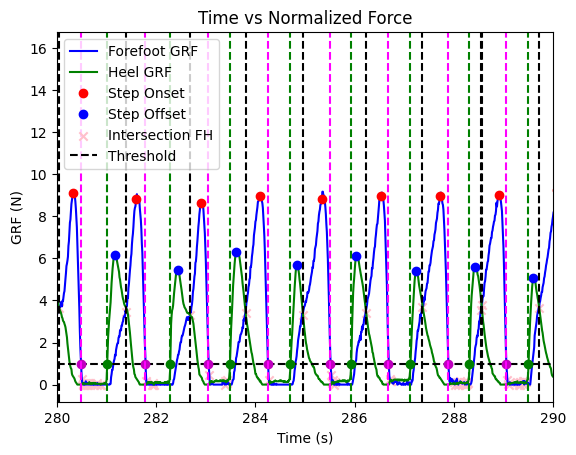

In [259]:
# Set minimum peak height and distance between peaks for forefoot signal
min_peak_height_ff = 7  
min_peak_distance_ff = 80  

# Find peaks in the Forefoot GRF signal
signal_ff = df['NormForefoot']
peaks_ff, _ = find_peaks(signal_ff, height=min_peak_height_ff, distance=min_peak_distance_ff)

# Add column to dataframe to indicate step onsets
df['Step Onset'] = False
df.loc[peaks_ff, 'Step Onset'] = True

# Set minimum peak height and distance between peaks for heel signal
min_peak_height_h = 3.5  
min_peak_distance_h = 80 

# Find peaks in the Heel GRF signal
signal_h = df['NormHeel']
peaks_h, _ = find_peaks(signal_h, height=min_peak_height_h, distance=min_peak_distance_h)

# Add column to dataframe to indicate step offsets
df['Step Offset'] = False
df.loc[peaks_h, 'Step Offset'] = True

# Extract the time and Forefoot/Heel data from the DataFrame
time = df['Time'].values
forefoot = df['NormForefoot'].values
heel = df['NormHeel'].values

# Create a boolean array for the true step onsets and offsets
true_step_onsets = df['Step Onset'].values
true_step_offsets = df['Step Offset'].values

# Plot the Forefoot and Heel GRF data
fig, ax = plt.subplots()
ax.plot(time, forefoot, label='Forefoot GRF', color='blue')
ax.plot(time, heel, label='Heel GRF', color='green')

# Plot a red dot at each true step onset
ax.plot(time[true_step_onsets], forefoot[true_step_onsets], 'ro', label='Step Onset')

# Plot a blue dot at each true step offset
ax.plot(time[true_step_offsets], heel[true_step_offsets], 'bo', label='Step Offset')




#Find the intersection points for all combinations of columns
indices_fh, intersection_times_fh, x_values_fh = find_intersection(df, 'NormForefoot', 'NormHeel')

plt.scatter(intersection_times_fh, df.iloc[indices_fh]['NormForefoot'].values, label='Intersection FH', color='pink', marker='x')

# Display the x coordinate of the intersections that have y>2
for i in range(len(intersection_times_fh)):
    if df.iloc[indices_fh[i]]['NormForefoot'] >= 2:
       plt.axvline(x=intersection_times_fh[i], color='black', linestyle='--')




# Set x-axis limits
ax.set_xlim(280, 290)



# Add horizontal line at y=1
ax.axhline(y=1, color='k', linestyle='--', label='Threshold')

# Add green dots where the Heel signal crosses y=1 with positive slope
for i in range(len(heel)-1):
    if heel[i] < 1 and heel[i+1] > 1 and (heel[i+1]-heel[i])/(time[i+1]-time[i]) > 0:
        ax.plot(time[i], 1, 'go')
        ax.axvline(x=time[i], color='green', linestyle='--')

# Add magenta dots where the Forefoot signal crosses y=1 with negative slope
for i in range(len(forefoot)-1):
    if forefoot[i] > 1 and forefoot[i+1] < 1 and (forefoot[i+1]-forefoot[i])/(time[i+1]-time[i]) < 0:
        ax.plot(time[i], 1, 'mo')
        ax.axvline(x=time[i], color='magenta', linestyle='--')
                
                

# Label the plot
ax.set_xlabel('Time (s)')
ax.set_ylabel('GRF (N)')
ax.set_title('Time vs Normalized Force')
ax.legend()

# Show the plot
plt.show()

In [260]:
# Initialize variables
green_dot_found = False
last_magenta_dot = None
steps = []
step_number = 1

# Loop through the time and Forefoot/Heel data
for i in range(len(time)):
    # Check if Forefoot signal crosses y=1 with negative slope after the green dot
    if green_dot_found and forefoot[i] < 1 and forefoot[i-1] > 1 and (forefoot[i]-forefoot[i-1])/(time[i]-time[i-1]) < 0:
        last_magenta_dot = time[i]
        green_dot_found = False
        steps.append((step_number, green_dot, last_magenta_dot))
        step_number += 1
    
    # Check if Heel signal crosses y=1 with positive slope before the magenta dot
    if not green_dot_found and heel[i] > 1 and heel[i-1] < 1 and (heel[i]-heel[i-1])/(time[i]-time[i-1]) > 0:
        green_dot = time[i]
        green_dot_found = True

# Print the extracted steps
for step in steps:
    print(f"Step {step[0]}: ({step[1]}, {step[2]})")

Step 1: (0.01, 8.9)
Step 2: (9.47, 12.32)
Step 3: (13.14, 13.5)
Step 4: (14.08, 15.98)
Step 5: (16.64, 17.41)
Step 6: (18.01, 19.46)
Step 7: (20.1, 21.31)
Step 8: (21.92, 23.22)
Step 9: (23.86, 25.37)
Step 10: (26.72, 27.81)
Step 11: (28.32, 29.37)
Step 12: (29.99, 30.86)
Step 13: (31.39, 32.33)
Step 14: (32.88, 33.76)
Step 15: (34.32, 35.2)
Step 16: (35.78, 36.69)
Step 17: (37.24, 38.1)
Step 18: (38.65, 39.53)
Step 19: (40.08, 40.95)
Step 20: (41.47, 42.33)
Step 21: (42.84, 43.7)
Step 22: (44.25, 44.47)
Step 23: (45.6, 45.83)
Step 24: (46.99, 47.82)
Step 25: (48.35, 49.22)
Step 26: (49.73, 50.58)
Step 27: (51.09, 52.01)
Step 28: (52.57, 53.44)
Step 29: (53.94, 54.8)
Step 30: (55.33, 56.18)
Step 31: (56.67, 57.5)
Step 32: (57.99, 58.86)
Step 33: (59.38, 60.21)
Step 34: (60.72, 61.58)
Step 35: (62.09, 62.98)
Step 36: (63.46, 64.31)
Step 37: (64.8, 65.65)
Step 38: (66.15, 66.99)
Step 39: (67.49, 67.74)
Step 40: (68.84, 69.08)
Step 41: (70.2, 71.04)
Step 42: (71.55, 72.4)
Step 43: (72.9, 

In [261]:
# Create a new column called "Step" and initialize all values to "stand off phase"
df['Step'] = 'stand off phase'

# Loop through the steps and assign step numbers to corresponding rows in the dataframe
for step in steps:
    df.loc[(df['Time'] >= step[1]) & (df['Time'] <= step[2]), 'Step'] = f"Step {step[0]}"

# Print the updated dataframe
df.head()

,Time,Forefoot,Midfoot,Heel,Total,NormForefoot,NormMidfoot,NormHeel,NormTotal,AT_loading,Speed,Incline,Combined,Step Onset,Step Offset,Step
1,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,no label,no label,no label_no label,False,False,stand off phase
2,0.01,139.38,22.08,172.50,333.96,2.212381,0.350476,2.738095,5.300952,0.000765,no label,no label,no label_no label,False,False,Step 1
3,0.02,134.55,29.67,169.74,333.96,2.135714,0.470952,2.694286,5.300952,0.000763,no label,no label,no label_no label,False,False,Step 1
4,0.03,137.31,24.84,169.74,331.89,2.179524,0.394286,2.694286,5.268095,0.000756,no label,no label,no label_no label,False,False,Step 1
5,0.04,129.72,26.91,166.98,323.61,2.059048,0.427143,2.650476,5.136667,0.000751,no label,no label,no label_no label,False,False,Step 1


In [262]:
#drop rows that have no labels or that are in the stand off phase

df = df[~df.isin(['no label', 'stand off phase']).any(axis=1)]
df = df.drop(['Step Onset', 'Step Offset'], axis=1)

df.head()

,Time,Forefoot,Midfoot,Heel,Total,NormForefoot,NormMidfoot,NormHeel,NormTotal,AT_loading,Speed,Incline,Combined,Step
3001,30.00,0.0,0.0,104.0,104.0,0.0,0.000000,1.650794,1.650794,0.000514,warm_up,0,warm_up_0,Step 12
3002,30.01,0.0,3.9,124.8,128.7,0.0,0.061905,1.980952,2.042857,0.000622,warm_up,0,warm_up_0,Step 12
3003,30.02,0.0,0.0,144.3,144.3,0.0,0.000000,2.290476,2.290476,0.000714,warm_up,0,warm_up_0,Step 12
3004,30.03,0.0,1.3,162.5,163.8,0.0,0.020635,2.579365,2.600000,0.000805,warm_up,0,warm_up_0,Step 12
3005,30.04,0.0,6.5,174.2,180.7,0.0,0.103175,2.765079,2.868254,0.000869,warm_up,0,warm_up_0,Step 12


In [ ]:
###################################################################################################################

In [ ]:
###################################################################################################################